# **Import Libraries**

In [6]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

# **Upload Train and Test Images**

In [7]:
# Install Kaggle library in Colab

# !pip install kaggle
# Requirement already satisfied

# Move Kaggle API token to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Set appropriate permissions for the Kaggle API token
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset using Kaggle API
!kaggle datasets download -d aadityasinghal/facial-expression-dataset
# Unzip the downloaded file
!unzip /content/facial-expression-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

# **Initialize train and test directories**

In [8]:
TRAIN_DIR = '/content/train/train/'
TEST_DIR = '/content/test/test/'

# **Define function to load image paths with coresponding labels from images directory**

In [9]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

# **Create data frame for training data**

In [10]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

disgust Completed
neutral Completed
angry Completed
surprise Completed
fear Completed
happy Completed
sad Completed


,image,label
0,/content/train/train/happy/Training_77225496.jpg,happy
1,/content/train/train/neutral/Training_62167953...,neutral
2,/content/train/train/happy/Training_82432472.jpg,happy
3,/content/train/train/neutral/Training_65418242...,neutral
4,/content/train/train/happy/Training_84837955.jpg,happy


# **Create data frame for testing data**

In [11]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

disgust Completed
neutral Completed
angry Completed
surprise Completed
fear Completed
happy Completed
sad Completed


,image,label
0,/content/test/test/disgust/PrivateTest_6026557...,disgust
1,/content/test/test/disgust/PrivateTest_9339075...,disgust
2,/content/test/test/disgust/PrivateTest_9525026...,disgust
3,/content/test/test/disgust/PrivateTest_3929526...,disgust
4,/content/test/test/disgust/PrivateTest_7983119...,disgust


# **Exploratory Data Analysis**

<ipython-input-12-770861a4f374>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train['label'] , palette='bright')


<Axes: xlabel='label', ylabel='count'>

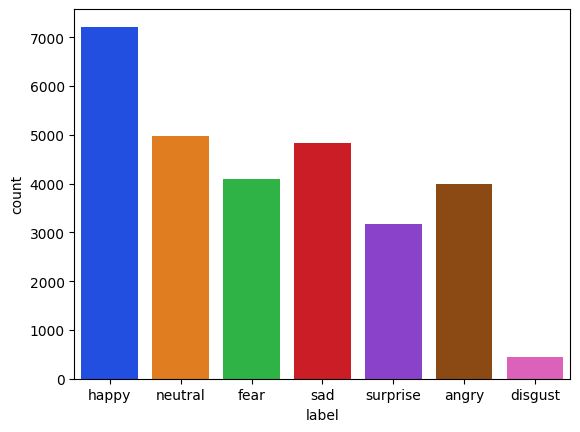

In [12]:
sns.countplot(x=train['label'] , palette='bright')

# **Show sample image**

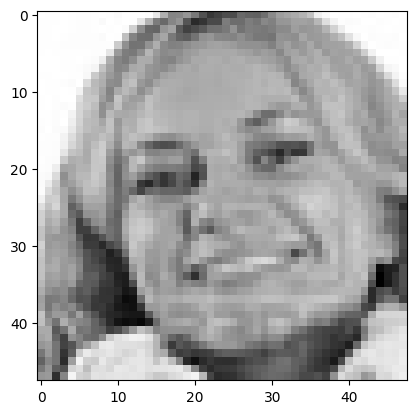

In [13]:
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

# **Display grid of images**

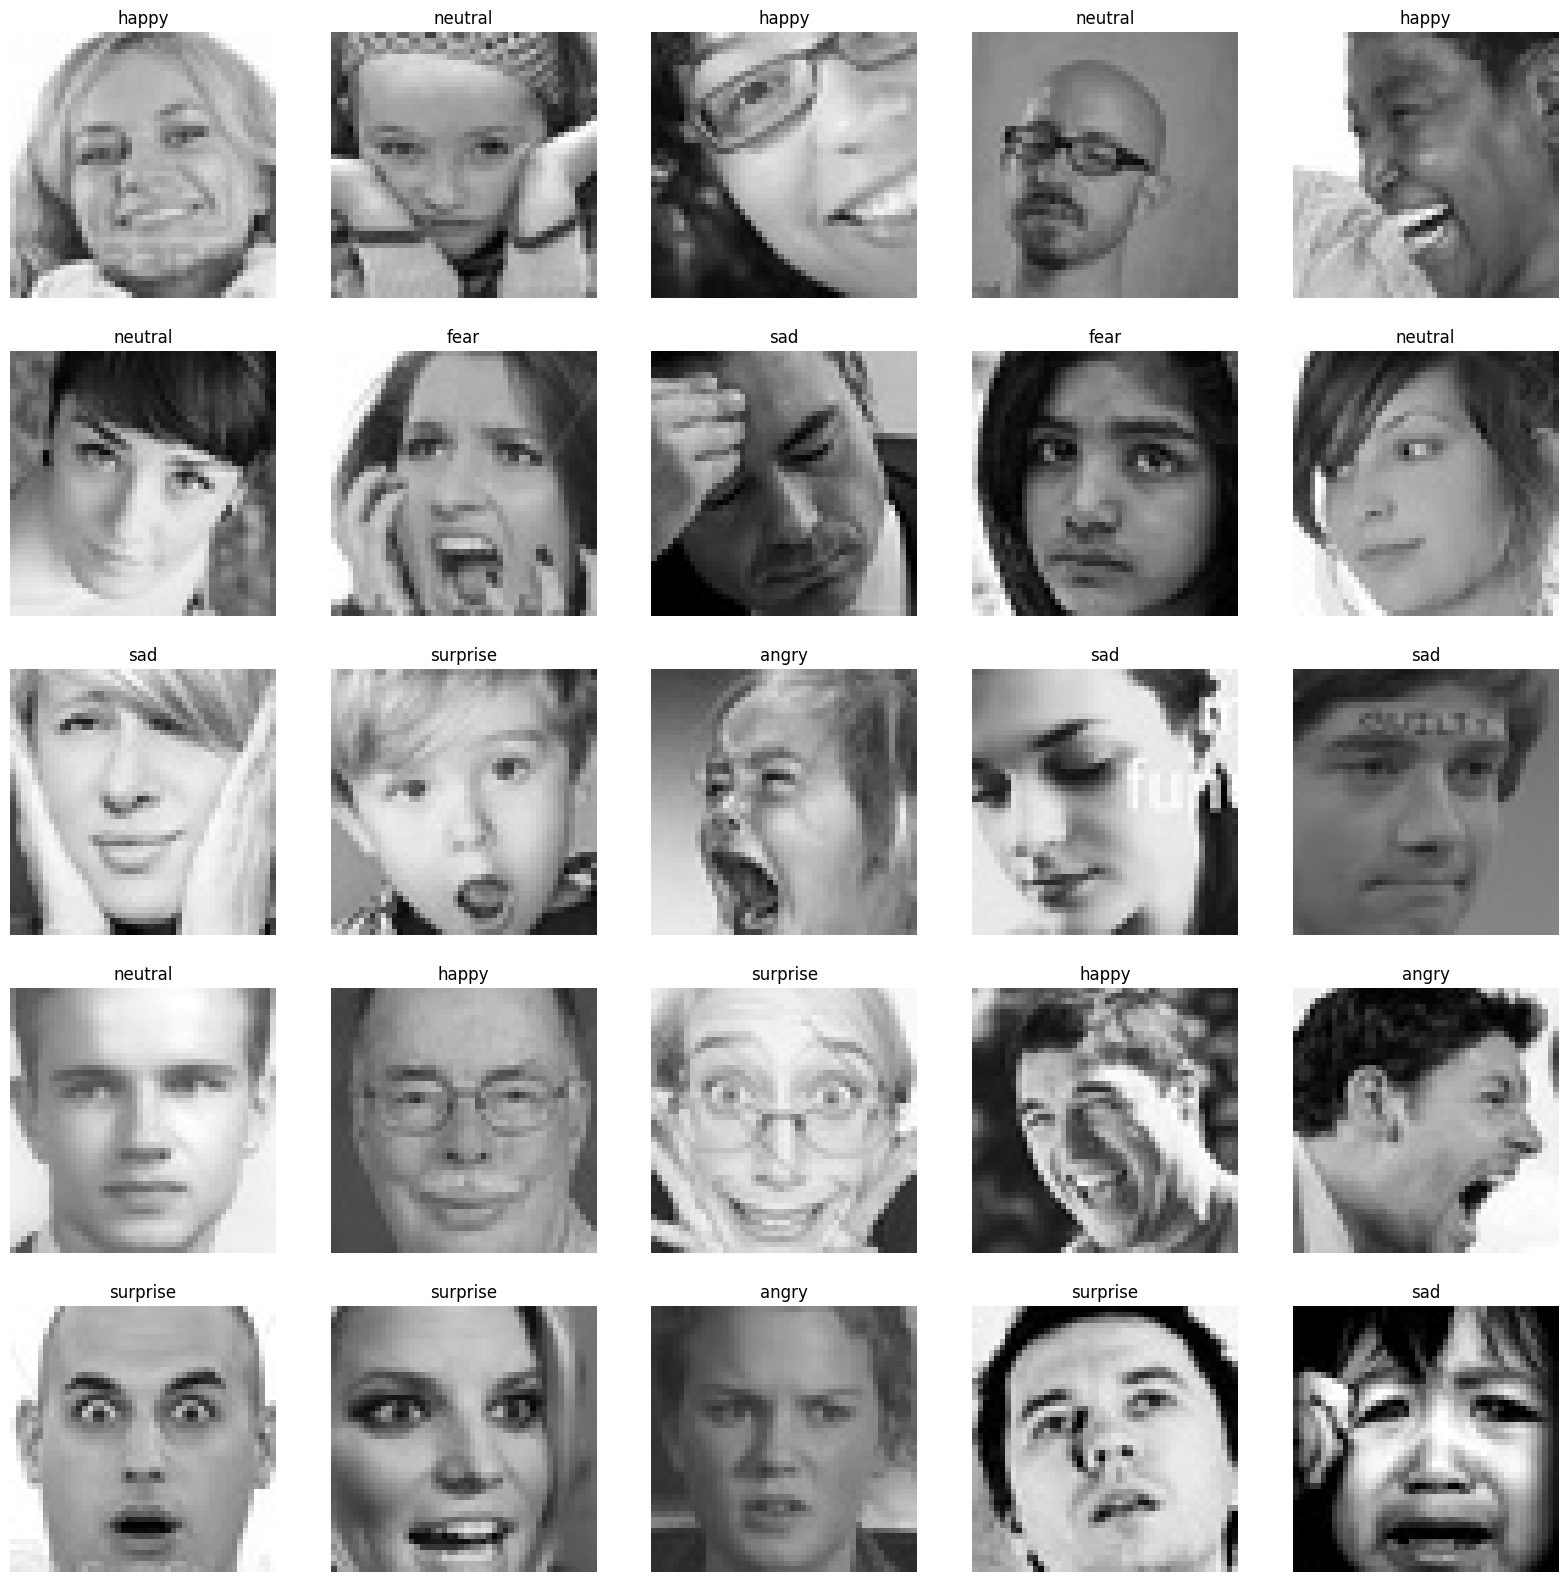

In [14]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

# **Extract the features**

In [15]:
def extract_features(images):
    features = []
    for image in images:
        img = load_img(image, color_mode="grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)

    # Flattening the image,  reshape each image into a single array of (48x48 = 2304)continuous pixels
    features = features.reshape(len(features), 48, 48, 1)

    # image data has been reshaped and is now a collection of 1D arrays containing 2304 pixel values each
    return features

In [16]:
train_features = extract_features(train['image'])

In [17]:
test_features = extract_features(test['image'])

# **Normalizing the Image Data, Converting integer values to floating point values**

In [18]:
## normalize the image

# Deep learning models are better at dealing with floating point numbers between 0 and 1
# Divide all the pixel values (which if you recall are between 0 and 255) by 255

x_train = train_features/255.0
x_test = test_features/255.0

# **Categorically Encoding the Labels**

In [19]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder

# The LabelEncoder class is used for encoding labels with a value between 0 and n_classes-1.
le = LabelEncoder()

# First use fit() to fit the encoder to your data
le.fit(train['label'])

# Then you can use transform() to encode labels based on that fitted encoder.
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [20]:
# to_categorical is used to convert class vectors (integers) to binary class matrices.
# This function is commonly used in multi-class classification problems when the target variable is represented as integers

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [21]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [22]:
# config
input_shape = (48, 48, 1)
output_class = 7

# **Creating the Model**

In [23]:
from keras.layers import BatchNormalization

# Model Creation

# Instantiate an instance of a model that will have a series of layers
model = Sequential()

# Creating the Input Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))

# Creating the Hidden Layers

model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))

model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))

model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(1024, kernel_size=(3,3), activation='relu'))

model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))

model.add(BatchNormalization())

model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))

model.add(BatchNormalization())

model.add(Dropout(0.3))

# Creating the Output layer

# Since the network is to make a guess about a single image belonging to 1 of 7 possible categories
# There will be 7 outputs. Each output gives the model's guess (a probability) that the image belongs to that specific class
model.add(Dense(output_class, activation='softmax'))


# **Summarize the model**

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       1280      
                                                                 
 batch_normalization (Batch  (None, 46, 46, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 256)       1

# **Compile the model**

In [25]:
# Specify a loss function which will be used for the model to understand how well it is performing during training.
# Specify that we would like to track accuracy while the model trains
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# accuracy states how well the model did for the epoch on all the training data.
# val_accuracy states how well the model did on the validation data

# **Train the model**

In [26]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
225/225 [==============================] - 33s 88ms/step - loss: 2.1026 - accuracy: 0.2311 - val_loss: 3.6271 - val_accuracy: 0.1427
Epoch 2/100
225/225 [==============================] - 18s 78ms/step - loss: 1.6428 - accuracy: 0.3686 - val_loss: 2.3464 - val_accuracy: 0.2643
Epoch 3/100
225/225 [==============================] - 18s 81ms/step - loss: 1.4270 - accuracy: 0.4533 - val_loss: 1.4458 - val_accuracy: 0.4489
Epoch 4/100
225/225 [==============================] - 18s 82ms/step - loss: 1.3075 - accuracy: 0.4996 - val_loss: 1.4645 - val_accuracy: 0.4565
Epoch 5/100
225/225 [==============================] - 19s 83ms/step - loss: 1.2311 - accuracy: 0.5319 - val_loss: 1.2786 - val_accuracy: 0.5060
Epoch 6/100
225/225 [==============================] - 18s 79ms/step - loss: 1.1781 - accuracy: 0.5506 - val_loss: 1.1874 - val_accuracy: 0.5458
Epoch 7/100
225/225 [==============================] - 18s 82ms/step - loss: 1.1268 - accuracy: 0.5736 - val_loss: 1.4326 - val_ac

# **Saving the model to an H5 File**

In [27]:
model.save("model.h5")
model.save_weights("weights.h5")
print("Model saved to disk.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk.


# **Loading the model from an H5 File**

In [28]:
# Load the model from the H5 file
loaded_model = load_model("model.h5")
# Load model weights into the new model
loaded_model.load_weights("weights.h5")
print("Model loaded from disk.")

Model loaded from disk.


# **Detect emotion type from image**

Original Output: sad
1/1 [==============================] - 0s 19ms/step
Predicted Output: sad


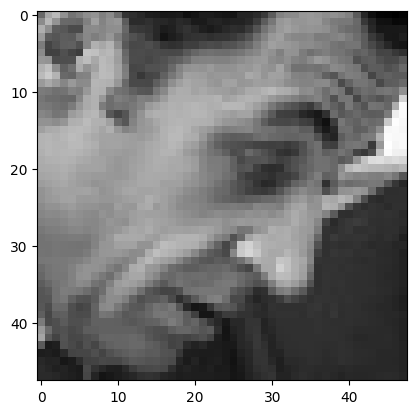

In [41]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])

# pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
pred = loaded_model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)

plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');